In [70]:
%load_ext autoreload
%autoreload 2

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer, initialize_weights, train_model, train_hooked_model
from markov_utilities import (
    calculate_sequence_probabilities,
    compute_myopic_entropy_from_MSP,
    epsilon_machine_to_graph,
    get_recurrent_subgraph,
    to_mixed_state_presentation,
    get_recurrent_subgraph,
    calculate_empirical_sequence_probabilities,
    create_transition_matrix,
    to_probability_distributions
)


from entropy_analysis import (
    compute_conditional_entropy,
    compute_empirical_conditional_entropy,
    inverse_binary_entropy,

)

from error_analysis import (
    compute_minimum_error,
)



from visualization import visualize_graph
from processes import RRXORProcess, GoldenMeanProcess, ZeroOneRProcess, EvenProcess, Mess3Process


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[-0.5+0.8660254j -0.5-0.8660254j  1. +0.j       ] [[ 0.28867513+0.5j  0.28867513-0.5j -0.57735027+0.j ]
 [ 0.28867513-0.5j  0.28867513+0.5j -0.57735027+0.j ]
 [-0.57735027+0.j  -0.57735027-0.j  -0.57735027+0.j ]]
[[0.33333333]
 [0.33333333]
 [0.33333333]]


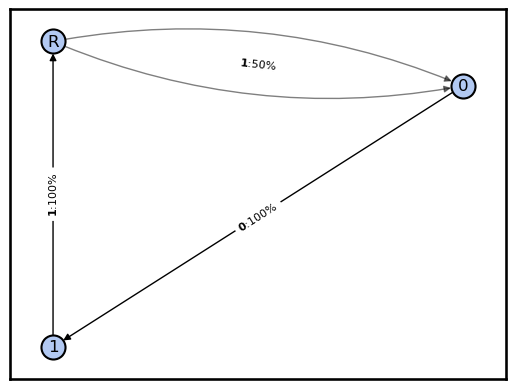

In [71]:
Z1R = ZeroOneRProcess()

# visualize the epsilon machine
graph = epsilon_machine_to_graph(Z1R.T, Z1R.state_names)
visualize_graph(graph, layout="spectral", draw_mixed_state=True, pdf="zero_one_r_epsilon.pdf")


[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[-0.5+0.8660254j -0.5-0.8660254j  1. +0.j       ] [[ 0.28867513+0.5j  0.28867513-0.5j -0.57735027+0.j ]
 [ 0.28867513-0.5j  0.28867513+0.5j -0.57735027+0.j ]
 [-0.57735027+0.j  -0.57735027-0.j  -0.57735027+0.j ]]
[[0.33333333]
 [0.33333333]
 [0.33333333]]


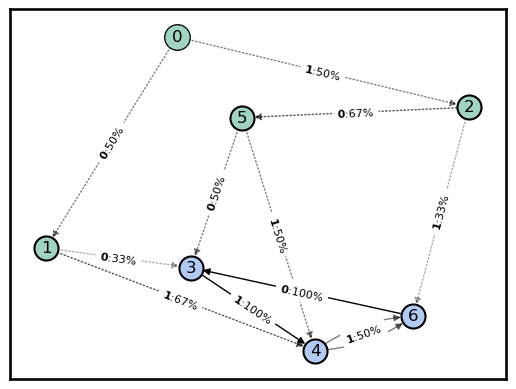

In [72]:
MSP = to_mixed_state_presentation(Z1R.T, threshold=1e-5, max_depth=5)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph(G_MSP, layout='spring', draw_edge_labels=True,
                      
                                    draw_mixed_state=True, draw_color=False, pdf="zero_one_r_msp.pdf")

0.33333333333333326


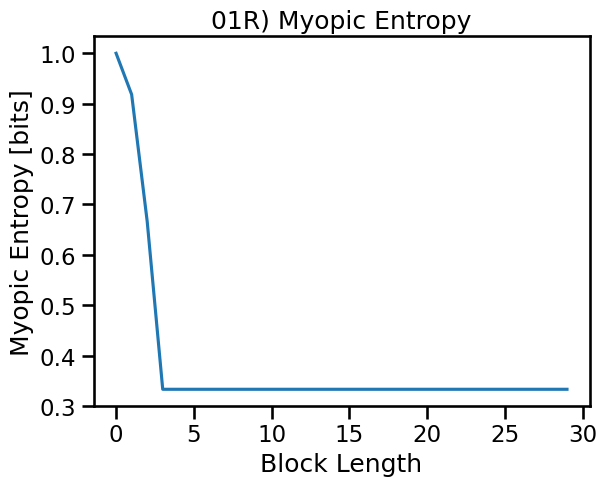

In [125]:

myopic_entropy = compute_myopic_entropy_from_MSP(MSP,30)
plt.plot(myopic_entropy)
plt.ylabel('Myopic Entropy [bits]'); plt.xlabel('Block Length'); plt.title('01R) Myopic Entropy')
print(myopic_entropy[-1])

In [124]:
from transformer_lens import HookedTransformer, HookedTransformerConfig

config = HookedTransformerConfig(
    d_model=32,
    d_head=8,
    n_layers=2,
    n_ctx=6,
    n_heads=4,
    d_mlp=4*32,
    d_vocab=2,
    act_fn='relu',
    use_attn_scale=True,
    normalization_type=None,
    attention_dir='causal',
    attn_only=False,
    seed=42,
    init_weights=True,
    device='cpu'
)

model = HookedTransformer(config)
# Define a config for the transformer and training
train_config = {
    # training config
    'batch_size': 128,
    'sequence_length': 5000,
    'num_epochs': 100,
    'learning_rate': 1.5e-4,
    'weight_decay': 1e-5,
    'patience': 100,
    'factor': 0.5
}

# Generate sequence data with positions
train_loader, test_loader, sequence_positions = Z1R.prepare_data(train_config['sequence_length'], model.cfg.n_ctx,
                                                                   split_ratio=0.8, batch_size=train_config['batch_size'],
                                                                   with_positions=True)

print(f"The number of batches in the training set is {len(train_loader)}")


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=train_config['learning_rate'], weight_decay=train_config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=train_config['patience'], factor=train_config['factor'], verbose=True)

model = train_hooked_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=train_config['num_epochs'], verbose=True)

The number of batches in the training set is 32
| Epoch | Training Acc. | Loss | Overall Acc. | Last Bit Acc. |
|   1   |    66.46%    |    0.6163     |      66.70%       |      66.82%      |
|   2   |    66.48%    |    0.6204     |      66.69%       |      66.61%      |
|   3   |    66.57%    |    0.6003     |      66.70%       |      66.72%      |
|   4   |    66.57%    |    0.5580     |      69.64%       |      66.75%      |
|   5   |    76.43%    |    0.5446     |      72.45%       |      84.34%      |
|   6   |    83.48%    |    0.5206     |      72.32%       |      82.71%      |
|   7   |    83.66%    |    0.5092     |      72.33%       |      82.80%      |
|   8   |    83.31%    |    0.4720     |      73.97%       |      82.75%      |
|   9   |    83.53%    |    0.4512     |      75.79%       |      84.36%      |
|  10   |    83.70%    |    0.4205     |      75.68%       |      83.65%      |
|  11   |    84.14%    |    0.3831     |      76.50%       |      83.56%      |
|  12   

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# make the seaborn context prettier
sns.set_context('talk')

# define loss function as cross entropy loss, but no reduction
crossEntropy = nn.CrossEntropyLoss(reduction='none')

model.eval()
with torch.no_grad():
    # For train data
    train_loss = []
    train_accuracy = []
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss = crossEntropy(output.view(-1, 2), target.view(-1))
        # Reshape loss back to original shape before saving
        train_loss.append(loss.view(data.shape[0], data.shape[1]).cpu().numpy())
        # prediction is argmax over last dimension, which is 2
        pred = output.data.max(2, keepdim=True)[1]
        correct = pred.squeeze() ==  data
        train_accuracy.append(correct.cpu().numpy())

    # For test data
    test_loss = []
    test_accuracy = []
    for data, target in test_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss = crossEntropy(output.view(-1, 2), target.view(-1))
        test_loss.append(loss.view(data.shape[0], data.shape[1]).cpu().numpy())
        pred = output.data.max(2, keepdim=True)[1]
        correct = pred.squeeze() ==  data
        test_accuracy.append(correct.cpu().numpy())


train_loss = np.concatenate(train_loss)
train_accuracy = np.concatenate(train_accuracy)
test_loss = np.concatenate(test_loss)
test_accuracy = np.concatenate(test_accuracy)

print('Train Loss: ', np.mean(train_loss))
print('Train Accuracy: ', np.mean(train_accuracy))
print('Test Loss: ', np.mean(test_loss))
print('Test Accuracy: ', np.mean(test_accuracy))


# Reshape the data to long format
train_loss_df = pd.DataFrame(train_loss).melt(var_name='context_position', value_name='loss')
train_loss_df['type'] = 'train'
test_loss_df = pd.DataFrame(test_loss).melt(var_name='context_position', value_name='loss')
test_loss_df['type'] = 'test'

# add 1 to context pos
train_loss_df['context_position'] += 1
test_loss_df['context_position'] += 1

# convert to bits from nats
train_loss_df['loss'] = np.log2(np.exp(train_loss_df['loss']))
test_loss_df['loss'] = np.log2(np.exp(test_loss_df['loss']))

# Concatenate the dataframes
loss_df = pd.concat([train_loss_df, test_loss_df])

Train Loss:  0.33888438
Train Accuracy:  0.2811430955360868
Test Loss:  0.33880448
Test Accuracy:  0.2884551217884551


/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



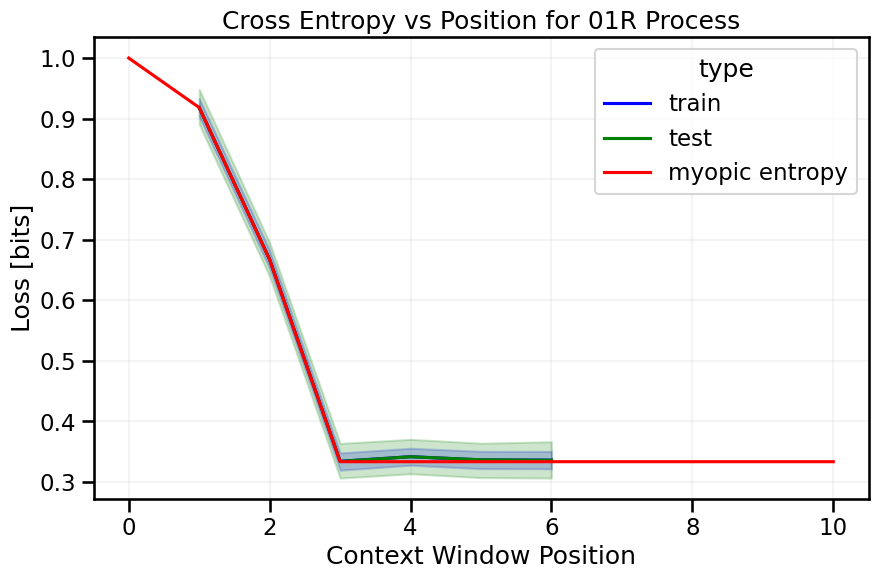

In [127]:
# Compute myopic entropy
myopic_entropy = compute_myopic_entropy_from_MSP(MSP,11)

# Create a DataFrame for myopic entropy
myopic_entropy_df = pd.DataFrame({
    'context_position': np.arange(len(myopic_entropy)),
    'loss': myopic_entropy,
    'type': 'myopic entropy'
})

# Concatenate the dataframes
loss_df = pd.concat([train_loss_df, test_loss_df, myopic_entropy_df])

# Define colors for each line
colors = {'train': 'blue', 'test': 'green', 'myopic entropy': 'red'}

# Plot using seaborn
plt.figure(figsize=(10, 6))
plt.grid(True)  # Add a grid for better readability
# make grid lighter
plt.gca().set_axisbelow(True)
plt.grid(which='major', color='#999999', linestyle='-', alpha=0.1)
sns.lineplot(data=loss_df, x='context_position', y='loss', hue='type', palette=colors)
plt.ylabel('Loss [bits]')
plt.xlabel('Context Window Position')
plt.title('Cross Entropy vs Position for 01R Process')
plt.show()

In [128]:
probs = to_probability_distributions(Z1R.T,7,1e-100)
probs

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[-0.5+0.8660254j -0.5-0.8660254j  1. +0.j       ] [[ 0.28867513+0.5j  0.28867513-0.5j -0.57735027+0.j ]
 [ 0.28867513-0.5j  0.28867513+0.5j -0.57735027+0.j ]
 [-0.57735027+0.j  -0.57735027-0.j  -0.57735027+0.j ]]
[[0.33333333]
 [0.33333333]
 [0.33333333]]


[array([0.33333333, 0.33333333, 0.33333333]),
 array([0.33333333, 0.66666667, 0.        ]),
 array([0.33333333, 0.        , 0.66666667]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([0.5, 0.5, 0. ]),
 array([1., 0., 0.])]

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



<bound method TernaryAxesSubplot.show of TernaryAxesSubplot: 756757149>

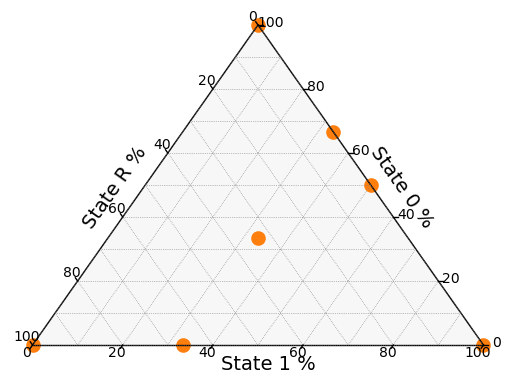

In [129]:
import pandas as pd
import plotly.express as px
import ternary
df = pd.DataFrame([100*p for p in probs], columns=['0', '1', 'R'])
fig, tax = ternary.figure(scale=100)

# Axis labels. (See below for corner labels.)
fontsize = 14
offset = 0.08
tax.left_axis_label("State R %", fontsize=fontsize, offset=offset)
tax.right_axis_label("State 0 %", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("State 1 %", fontsize=fontsize, offset=-offset)


tax.scatter(df[['0', '1', 'R']].values)
tax.boundary(linewidth=1)
tax.gridlines(multiple=10, color="gray")
tax.ticks(axis='lbr', linewidth=1, multiple=20)
tax.get_axes().axis('off')
tax.show

In [130]:
# get some training data and run it through the model
from tqdm import tqdm
datas = []
resids = []
for data, target in tqdm(train_loader):
    _, cache = model.run_with_cache(data, names_filter=lambda x: 'resid_post' in x)
    datas.extend(data)
    resids.append(cache["resid_post", model.cfg.n_layers-1])
resids = torch.concat(resids)
print(resids.shape) #(batch, ctx_pos, res_dim)

MSP_states = []
for d in datas:
    this_data = []
    from_state = 0
    for p in d:
        emission = p
        transition_probs = MSP[p,from_state,:]
        # find all nonzero index
        nonzero_indices = np.nonzero(transition_probs)[0]
        #print(nonzero_indices)
        if len(nonzero_indices) != 1:
            print('warning',nonzero_indices)
        from_state = nonzero_indices[0]
        this_data.append(from_state)
    MSP_states.append(this_data)


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 411.00it/s]

torch.Size([3995, 6, 32])


In [131]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrizations as parametrizations

class PlaneProjectionModel(nn.Module):
    def __init__(self, input_dim=16, output_dim=2):
        super(PlaneProjectionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

        # initialize
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, x):
        # Project the input to 2D with an offset in the 16D space
        return self.linear(x)
    

import plotly.express as px
import pandas as pd

# reshape resids and run pca on it
print(resids.shape)
resids_reshaped = resids.view(resids.shape[0]*resids.shape[1], -1)
MSP_states= torch.tensor(MSP_states)
MSP_states_reshaped = MSP_states.view(-1)
print(MSP_states_reshaped.shape)
print(resids_reshaped.shape)



torch.Size([3995, 6, 32])
torch.Size([23970])
torch.Size([23970, 32])


In [132]:
from sklearn.linear_model import ElasticNetCV
from sklearn.multioutput import MultiOutputRegressor
from collections import Counter

state_prob_dict = dict(zip(range(len(probs)),probs))
state_counts = Counter([int(x) for x in MSP_states_reshaped])
print(state_counts)

print(resids_reshaped.shape, MSP_states_reshaped.shape)

# for each of the MSP_states_reshaped, map it to  probs using state_prob_dict
# and weight it according to its frequency of occurrence
target_distributions = np.array([state_prob_dict[int(x)] for x in MSP_states_reshaped])
weights = np.array([state_counts[int(x)] for x in MSP_states_reshaped])
print(target_distributions.shape)


# Initialize MultiOutputRegressor with an ElasticNetCV model
model = MultiOutputRegressor(ElasticNetCV(cv=2, random_state=0))
# The ElasticNetCV model will try out 100 alphas along the regularization path by default
# It will also perform 5-fold cross-validation due to cv=5

# Fit the model to your data using the weights
model.fit(resids_reshaped, target_distributions)#, sample_weight=weights)

# Predict the distributions for new data
predicted_distributions = model.predict(resids_reshaped)


Counter({4: 6658, 3: 6003, 6: 5982, 1: 2007, 2: 1988, 5: 1332})
torch.Size([23970, 32]) torch.Size([23970])
(23970, 3)


/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3665224465324499, tolerance: 0.2045988003522934

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6035076412563285, tolerance: 0.2045988003522934

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6984594474489825, tolerance: 0.2045988003522934

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: Co

In [133]:
import plotly.express as px
import pandas as pd

# Convert the predicted_distributions and MSP_states_reshaped to a DataFrame
df = pd.DataFrame(np.concatenate((predicted_distributions, MSP_states_reshaped.reshape(-1,1)), axis=1), columns=['x', 'y', 'z', 'label'])
df['label'] = df['label'].astype(str)

# Create a color sequence based on the unique labels in ascending order
color_sequence = px.colors.qualitative.Plotly[:len(df['label'].unique())]

# Create a 3D scatter plot using plotly express with color based on the msp_state label
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', color_discrete_sequence=color_sequence)
fig.show()

# Project the data to the x+y+z=1 plane
df['x_proj'] = df['x'] / (df['x'] + df['y'] + df['z'])
df['y_proj'] = df['y'] / (df['x'] + df['y'] + df['z'])

# Plot the projected data on the 2D plane
# Use the same discrete colorscale
fig = px.scatter(df, x='x_proj', y='y_proj', color='label', color_discrete_sequence=color_sequence)
fig.show()


In [117]:
probs_to_plot = np.array([np.array(x) for x in probs])
df_probs = pd.DataFrame(probs_to_plot, columns=['x', 'y', 'z'])
df_probs['label'] = [str(x) for x in range(len(probs_to_plot))]

fig = px.scatter_3d(df_probs, x='x', y='y', z='z', color='label', color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()

df_probs['x_proj'] = df_probs['x'] / (df_probs['x'] + df_probs['y'] + df_probs['z'])
df_probs['y_proj'] = df_probs['y'] / (df_probs['x'] + df_probs['y'] + df_probs['z'])

fig = px.scatter(df_probs, x='x_proj', y='y_proj', color='label', color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()


/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



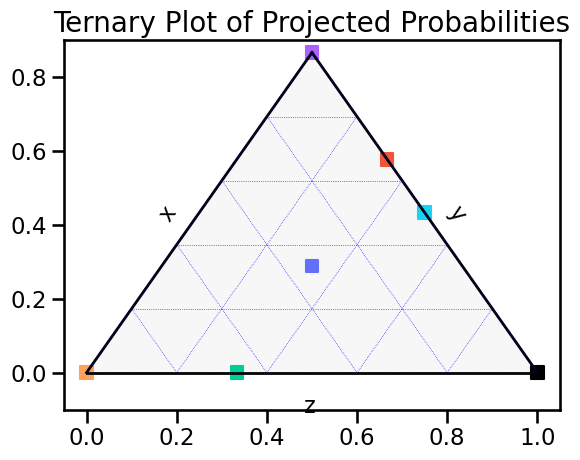

In [134]:
import ternary

# Create a ternary plot
figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.2, color="blue")

# Plot the data with color based on the label
# Check if the label is a digit and within the range of color_sequence before applying color
colors = df_probs['label'].apply(lambda x: color_sequence[int(x)] if x.isdigit() and int(x) < len(color_sequence) else 'black')
tax.scatter(df_probs[['x', 'y', 'z']].values, marker='s', color=colors, label="Projected Probabilities")

# Set labels and title
tax.set_title("Ternary Plot of Projected Probabilities", fontsize=20)
tax.left_axis_label("x", fontsize=16)
tax.right_axis_label("y", fontsize=16)
tax.bottom_axis_label("z", fontsize=16)

# Show the plot
tax.show()


/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



<bound method TernaryAxesSubplot.show of TernaryAxesSubplot: 748175441>

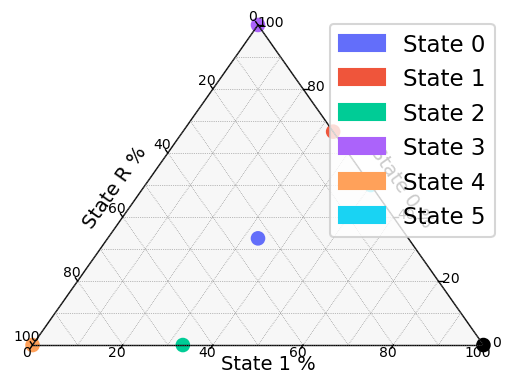

In [135]:
import pandas as pd
import plotly.express as px
import ternary
df = pd.DataFrame([100*p for p in probs], columns=['0', '1', 'R'])
df['label'] = [str(x) for x in range(len(probs))]
fig, tax = ternary.figure(scale=100)

# Axis labels. (See below for corner labels.)
fontsize = 14
offset = 0.08
tax.left_axis_label("State R %", fontsize=fontsize, offset=offset)
tax.right_axis_label("State 0 %", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("State 1 %", fontsize=fontsize, offset=-offset)

# Add colors and legend
colors = df['label'].apply(lambda x: color_sequence[int(x)] if x.isdigit() and int(x) < len(color_sequence) else 'black')
tax.scatter(df[['0', '1', 'R']].values, color=colors, label="Projected Probabilities")

# Adding legend entries for each state
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(color=color_sequence[i], label='State {}'.format(i)) for i in range(len(color_sequence))]
tax.legend(handles=legend_elements, loc='upper right')

tax.boundary(linewidth=1)
tax.gridlines(multiple=10, color="gray")
tax.ticks(axis='lbr', linewidth=1, multiple=20)
tax.get_axes().axis('off')
tax.show

In [136]:
df


0           1           R label
0   33.333333   33.333333   33.333333     0
1   33.333333   66.666667    0.000000     1
2   33.333333    0.000000   66.666667     2
3    0.000000  100.000000    0.000000     3
4    0.000000    0.000000  100.000000     4
5   50.000000   50.000000    0.000000     5
6  100.000000    0.000000    0.000000     6

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



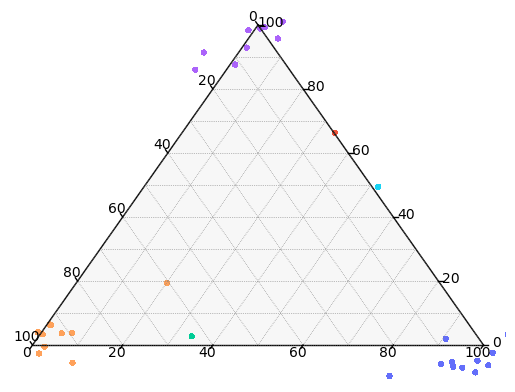

In [137]:
import ternary

# Convert the predicted_distributions and MSP_states_reshaped to a DataFrame
df = pd.DataFrame(np.concatenate((predicted_distributions, MSP_states_reshaped.reshape(-1,1)), axis=1), columns=['x', 'y', 'z', 'label'])
df[['x', 'y', 'z']] = df[['x', 'y', 'z']] * 100

df['label'] = df['label'].astype(int).astype(str)


# Create a color sequence based on the unique labels in ascending order
color_sequence = px.colors.qualitative.Plotly[:len(df['label'].unique())]

# Create a ternary plot using the ternary library
fig, tax = ternary.figure(scale=100)
tax.scatter(df[['x', 'y', 'z']].values, color=df['label'].apply(lambda x: color_sequence[int(x)] if x.isdigit() and int(x) < len(color_sequence) else color_sequence[0]), label="Projected Probabilities",s=5)
tax.boundary(linewidth=1)
tax.gridlines(multiple=10, color="gray")
tax.ticks(axis='lbr', linewidth=1, multiple=20)
tax.get_axes().axis('off')
tax.show()


/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



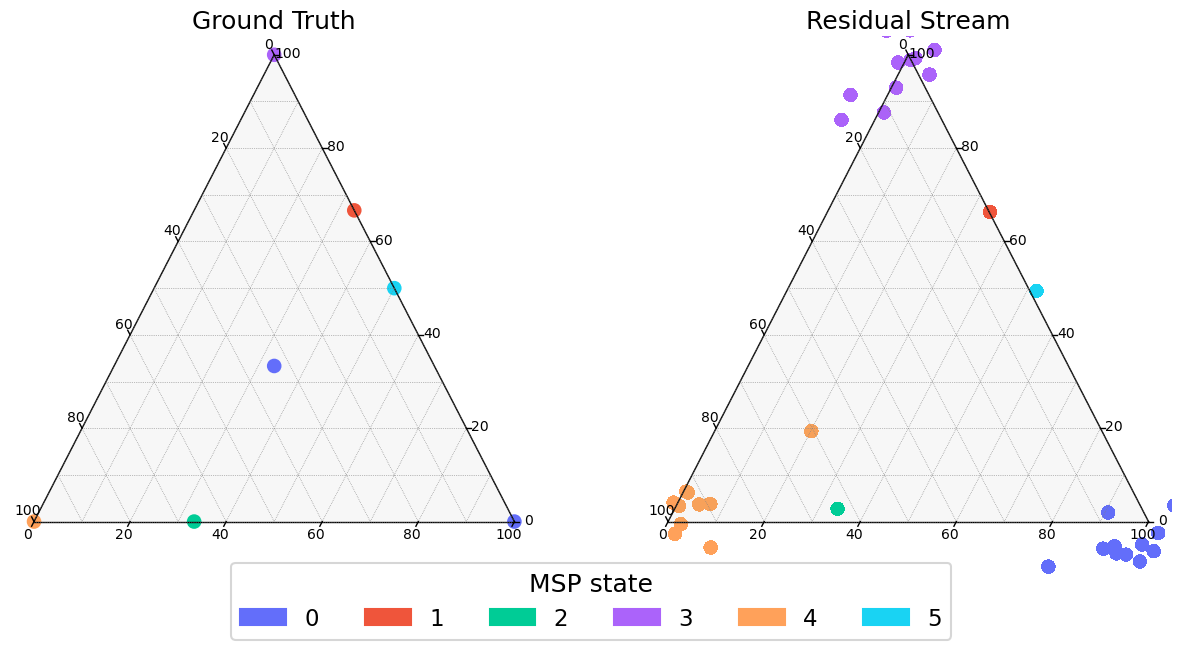

In [139]:
import matplotlib.pyplot as plt

# Create a new figure
fig = plt.figure(figsize=(15, 7))

# Add first subplot for the first ternary plot
ax1 = fig.add_subplot(121)

# Create a ternary plot in the first subplot
tax1 = ternary.TernaryAxesSubplot(ax=ax1, scale=100)
df2 = pd.DataFrame([100*p for p in probs], columns=['0', '1', 'R'])
df2['label'] = [str(x) for x in range(len(probs))]
tax1.scatter(df2[['0', '1', 'R']].values, color=df2['label'].apply(lambda x: color_sequence[int(x)] if x.isdigit() and int(x) < len(color_sequence) else color_sequence[0]), label="Projected Probabilities",alpha=1)
tax1.boundary(linewidth=1)
tax1.gridlines(multiple=10, color="gray")
tax1.ticks(axis='lbr', linewidth=1, multiple=20)
tax1.get_axes().axis('off')
tax1.set_title("Ground Truth")  # Add title to the first plot

# Add second subplot for the second ternary plot
ax2 = fig.add_subplot(122)

# Create a ternary plot in the second subplot
tax2 = ternary.TernaryAxesSubplot(ax=ax2, scale=100)
tax2.scatter(df[['x', 'y', 'z']].values, color=df['label'].apply(lambda x: color_sequence[int(x)] if x.isdigit() and int(x) < len(color_sequence) else color_sequence[0]), alpha=0.002, label="Projected Probabilities")  # Added alpha=0.5 to make the points transparent
tax2.boundary(linewidth=1)
tax2.gridlines(multiple=10, color="gray")
tax2.ticks(axis='lbr', linewidth=1, multiple=20)
tax2.get_axes().axis('off')
tax2.set_title("Residual Stream")  # Add title to the second plot

# Create a single legend for both plots, placed underneath and going horizontal
legend_elements = [mpatches.Patch(color=color_sequence[i], label='{}'.format(i)) for i in range(len(color_sequence))]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), title="MSP state")

# Show the figure with the two ternary plots side by side
plt.show()

